# DROPOUT PREDICTION

This notebook is aimed to study the performance of Support Vector Machines, Gaussian Naive Bayes, Random Forest, Adaptative Boosting and Logistic Regression on the classification task of dropout prediction.

The document has the following sections:

1. Data Cleaning and Dropout Labeling Functions
2. Model evaluation Functions
3. Visualization Functions
4. Utility Functions
5. Data Loading
6. Data Cleaning and preparation
7. Experiments preparation
8. Experiments
9. Error Distribution Visualization
10. Permutation test

In [47]:
ensenyament = "G1077"
path = 'drop_figures/' + ensenyament
retrain_classifiers = True

In [48]:
import pandas as pd
import numpy as np
import math as mt
from sklearn import linear_model,svm
from sklearn.base import TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from sklearn.utils import multiclass
from itertools import compress
from IPython.display import display
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score,recall_score,precision_recall_fscore_support
from scipy import interp
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import scipy
import matplotlib.pyplot as plt
import operator
from time import time
from sklearn.decomposition import PCA
from operator import itemgetter
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
import re
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
import seaborn as sns
from sklearn import grid_search 
from scipy.stats import randint as sp_randint
from sklearn.metrics import accuracy_score,auc,f1_score,precision_score,recall_score
import sklearn
%matplotlib inline
from sklearn.metrics import confusion_matrix
from pandas.tools.plotting import radviz
from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import os.path
from sklearn.externals import joblib
from imblearn.combine import SMOTETomek
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from scipy.stats import pearsonr,spearmanr, kendalltau
from sklearn.preprocessing import PolynomialFeatures

plot_size = 10
plt.rcParams['figure.figsize'] = (plot_size, plot_size)

##1. Data Cleaning and Dropout Labeling Functions

The functions in this section have been used to clean the datasets and prepare them for dropout prediction.

In [49]:
#Function used to remove samples that would not contribute to the prediction of dropout

def cleanData(df,year):
    #Remove students with a mean score less than 2
    new_df = df.drop(df[df.mean(axis = 1) <= 2].index)
    drop_list = []
    
    #Remove students who do not follow standard enrollment
    for i in new_df.index:
        qual_student = qual[qual['id_alumne'] == i]
        years = np.sort(qual_student['any_matriculacio_assig'].unique())
        if len(years) < year: drop_list.append(i)
        else:
            if len(qual_student[qual_student['any_matriculacio_assig'] == years[year - 1]]) > 10:
                drop_list.append(i)
    new_df = new_df.drop(drop_list)
    return new_df


#Function used to label a dataset for dropout prediction
def dropoutLabeling(dropoutList, year = 1):
    dropout = []
    for i in dropoutList: #For each student
        l = qual[qual.id_alumne == i].any_matriculacio_assig.unique() #List of enrollment years
        if len(l) < year:
            ultima_matriculacio = l[-1]
            if ultima_matriculacio == 2014: dropout.append(-1)
            else: dropout.append(1)
        else:
            primera_matriculacio = l[year - 1]
            if (primera_matriculacio + 1 in l): dropout.append(0) #No dropout
            else:
                if primera_matriculacio == 2014: dropout.append(-1) #Not enough information
                else:
                    dropout.append(1) #Dropout
    d = pd.Series(dropout,index = dropoutList)
    
    if year == 3:
        for i in d[d == 1].index:
            if len(qual[qual['id_alumne'] == i].id_assig.unique()) >=  len(enseny_labels[ensenyament]) - 10: 
                d.loc[i] = 0

    calc_drop = d[d != -1]
    next_year_list = d[d == 0]
    return next_year_list.index.unique(), 100*calc_drop.sum()/float(len(calc_drop)), d
            
#Function to group the final grades of the students in a single column of the dataset.
def getMarks(df):
    pc = df['nota_primera_conv']
    sc = df['nota_segona_conv']
    s = {}
    index = pc.index
    r = pc - sc
    for i in index:
        if r.ix[i] < 0: s[i] = sc.ix[i]
        else: s[i] = pc.ix[i]
    
    return pd.Series(s)

##2. Model evaluation functions

The following functions have been used to train the models using different features vectors and preprocessing techniques.

In [50]:
#This function creates the dropout prediction pipe

def createPipes(classifiers_names,classifiers,noreduction = [-1], experiment = 0, smote = False):
    pipes = []
    for i in range(len(classifiers)):
        if experiment == 0:
            if smote:
                pipes.append(Pipeline([("imputer", Imputer()),('smote',SMOTETomek(ratio = 'auto',random_state = int(random_state))),("kbest", SelectKBest(k=1)),('scl', StandardScaler()),(classifiers_names[i],classifiers[i])]))
            else:
                pipes.append(Pipeline([("imputer", Imputer()),("kbest", SelectKBest(k=1)),('scl', StandardScaler()),(classifiers_names[i],classifiers[i])]))
        if experiment == 1:
            if smote:
                pipes.append(Pipeline([("imputer", Imputer()),('smote',SMOTETomek(ratio = 'auto',random_state = int(random_state))),('mean',FunctionTransformer(addMean)),("kbest", SelectKBest(k=1)),('scl', StandardScaler()),(classifiers_names[i],classifiers[i])]))
            else:
                pipes.append(Pipeline([("imputer", Imputer()),('mean',FunctionTransformer(addMean)),("kbest", SelectKBest(k=1)),('scl', StandardScaler()),(classifiers_names[i],classifiers[i])]))
        if experiment == 2:
            if smote:
                pipes.append(Pipeline([("imputer", Imputer()),('smote',SMOTETomek(ratio = 'auto',random_state = int(random_state))),('mean',FunctionTransformer(addMean)),('poly',PolynomialFeatures(2,include_bias=False)),("kbest", SelectKBest(k=1)),('scl', StandardScaler()),(classifiers_names[i],classifiers[i])]))
            else:
                pipes.append(Pipeline([("imputer", Imputer()),('mean',FunctionTransformer(addMean)),('poly',PolynomialFeatures(2,include_bias=False)),("kbest", SelectKBest(k=1)),('scl', StandardScaler()),(classifiers_names[i],classifiers[i])]))
        if experiment == 3:
            if smote:
                pipes.append(Pipeline([("imputer", Imputer()),('smote',SMOTETomek(ratio = 'auto',random_state = int(random_state))),('mean',FunctionTransformer(addMean)),('pca',FunctionTransformer(addPCA)),('poly',PolynomialFeatures(2,include_bias=False)),("kbest", SelectKBest(k=1)),('scl', StandardScaler()),(classifiers_names[i],classifiers[i])]))
            else:
                pipes.append(Pipeline([("imputer", Imputer()),('mean',FunctionTransformer(addMean)),('pca',FunctionTransformer(addPCA)),('poly',PolynomialFeatures(2,include_bias=False)),("kbest", SelectKBest(k=1)),('scl', StandardScaler()),(classifiers_names[i],classifiers[i])]))
    return pipes

#This function performs gridSearch on a set of given dropout prediction pipes.
def gridSearch(pipes,grids,X_train,y_train,classifiers_names,cv,scoring = "accuracy", n_jobs = -1, onlyrun = -1,ignore = 0, experiment = 0, smote = False):
    
    bestClassifiers = []
    bestParams = []
    classification_names = []
    
    results = {}
    
    for i in range(len(pipes)):
        
        if i == onlyrun or onlyrun == -1 and ignore != i:

            clf = GridSearchCV(pipes[i], param_grid = grids[i], scoring = scoring, cv = cv, n_jobs = n_jobs)
            clf.fit(X_train,y_train)
            
            print "Classifier: ", classifiers_names[i]
            print "Best Parameters: ", clf.best_params_
            
            if experiment == 0:
                feature_names_pipe = features_names
                if smote:
                    mask = list(clf.best_estimator_.steps[2][1].get_support())
                else:
                    mask = list(clf.best_estimator_.steps[1][1].get_support())
            if experiment == 1:
                feature_names_pipe = features_names + ['mean']
                if smote:
                    mask = list(clf.best_estimator_.steps[3][1].get_support())
                else:
                    mask = list(clf.best_estimator_.steps[2][1].get_support())
            if experiment == 2:
                if smote:
                    feature_names_pipe = clf.best_estimator_.steps[3][1].get_feature_names(input_features=features_names + ['mean'])
                    mask = list(clf.best_estimator_.steps[4][1].get_support())
                else:
                    feature_names_pipe = clf.best_estimator_.steps[2][1].get_feature_names(input_features=features_names + ['mean'])
                    mask = list(clf.best_estimator_.steps[3][1].get_support())
            if experiment == 3:
                if smote:
                    feature_names_pipe = clf.best_estimator_.steps[4][1].get_feature_names(input_features=features_names + ['mean','pca1','pca2'])
                    mask = list(clf.best_estimator_.steps[5][1].get_support())
                else:
                    feature_names_pipe = clf.best_estimator_.steps[3][1].get_feature_names(input_features=features_names + ['mean','pca1','pca2'])
                    mask = list(clf.best_estimator_.steps[4][1].get_support())
                    

            results[classifiers_names[i]] = clf.best_params_,list(compress(feature_names_pipe, mask)),clf.best_score_
            
            print "Selected features: ",list(compress(feature_names_pipe, mask))
            print "Best score: ", clf.best_score_
            print "-"*100

            bestClassifiers.append(clf.best_estimator_)
            bestParams.append(clf.best_params_)
            classification_names.append(classifiers_names[i])
        
    return bestClassifiers,bestParams,classification_names,results

#Function to print the results of the evaluation of the models 
def printClassReport(pipes,bestParams,classification_names):
    predictions = []
    decision_functions = []
    acc_val,rec_val,pre_val,f1_val = [],[],[],[]

    for i,clf in enumerate(pipes):

        y_pred = clf.predict(X_test)
        predictions.append(y_pred)
        y_score = clf.predict_proba(X_test)
        decision_functions.append(y_score)

        acc = accuracy_score(y_test,y_pred)
        rec = recall_score(y_test,y_pred)
        pre = precision_score(y_test,y_pred)
        f1 = f1_score(y_test,y_pred)

        acc_val.append(acc)
        rec_val.append(rec)
        pre_val.append(pre)
        f1_val.append(f1)

    for i,param in enumerate(bestParams):
        df = pd.DataFrame.from_dict(param,orient='index')
        df.rename(columns={0:'Param'},inplace=True)
        df.to_latex(path + '/params' + classification_names[i] + '.tex')

    classification_metrics = pd.DataFrame([acc_val,rec_val,pre_val,f1_val], index = ['Accuracy','Recall','Precision','F1'], columns = classification_names).T

    classification_metrics = np.round(classification_metrics,2)
    classification_metrics.to_latex(path + '/class_table' + ensenyament + '.tex')

    for i,col in enumerate(classification_metrics.columns):
        pd.DataFrame(classification_metrics[col]).to_latex(path + '/class_table' + ensenyament + classification_names[i] + '.tex',bold_rows = True)

    display(classification_metrics)
    return classification_metrics,predictions

## 3. Visualization functions 

The following functions have been used to provide insight on performance of the models. 

In [51]:
#Function to plot Precision-Recall curves
def plot_PR_curve(decision_function):
    fig = plt.figure()

    for i,y_score in enumerate(decision_functions):
        prec, reca, _ = precision_recall_curve(y_test,y_score[:,1])
        average_precision = average_precision_score(y_test, y_score[:,1])
        # Plot Precision-Recall curve
        #plt.clf()
        plt.plot(reca, prec, lw=2, label=classification_names[i] + ": " + str(round(average_precision,2)))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall')
        plt.legend(loc="best")

    plt.show()
    fig.savefig(path + '/PR-curve' + ensenyament, transparent=True,dpi = 350)
    
#Function to plot ROC curves
def plot_ROC_curve(decision_function):
    
    fig = plt.figure()

    for i,y_score in enumerate(decision_functions):
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
        roc_auc = auc(fpr, tpr)
        lw = 2
        plt.plot(fpr, tpr, lw=lw, label= classification_names[i] + ': (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="best")

    plt.show()
    fig.savefig(path + '/ROC' + ensenyament, transparent=True,dpi = 350)

#Function to plot Learning Curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring = "accuracy"):
    fs = 16
    plt.title(title,fontsize = 20)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Number of Training samples",fontsize = fs)
    plt.ylabel("Error",fontsize = fs)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(1 - train_scores, axis=1)
    train_scores_std = np.std(1 - train_scores, axis=1)
    test_scores_mean = np.mean(1 - test_scores, axis=1)
    test_scores_std = np.std(1 - test_scores, axis=1)
    plt.grid()

    """plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")"""
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="CV error")

    plt.legend(loc="best")
    return plt

#Function to plot a Confusion Matrix
def plotConfusionMatrix(y_test,predictions):

    for i,y_pred in enumerate(predictions):

        plt.figure()
        cnf_matrix = confusion_matrix(~y_test,~y_pred)
        df = pd.DataFrame(cnf_matrix,columns = ['Dropout','No dropout'],index = ['Dropout','No dropout'])
        sns_plot = sns.heatmap(df, annot=True, fmt="d", linewidths=.5)
        sns_plot.set_title(classification_names[i])
        sns_plot.get_figure().savefig(path + '/ConfMatrix' + ensenyament + classification_names[i], dpi = 350)
        
#Function to plot the error distribution of the predictions for a particular dataset
def plotErrorDistribution(df_tests):

    for i,df_test in enumerate(df_tests):

        f = plt.figure()

        plt.subplot(1,2,1)

        bar_width = 1

        opacity1 = 0.3
        opacity2 = 0.8

        index = np.arange(len(df_test.index))

        rects1 = plt.bar(index, df_test['total 0'], bar_width,
                         alpha=opacity1,
                         color='lightskyblue',
                         label='Real')

        rects2 = plt.bar(index, df_test['Correct 0'], bar_width,
                         alpha=opacity2,
                         color='royalblue',
                         label='Predicted')

        plt.xlabel('Mean grade')
        plt.ylabel('Number of Students')
        plt.title('No Dropout')
        plt.xticks(index, df_test.index)
        plt.legend()
        plt.grid(False)

        plt.subplot(1,2,2)

        bar_width = 1

        opacity1 = 0.3
        opacity2 = 0.8

        index = np.arange(8)

        rects1 = plt.bar(index, df_test['total 1'], bar_width,
                         alpha=opacity1,
                         color='lightcoral',
                         label='Real')

        rects2 = plt.bar(index, df_test['Correct 1'], bar_width,
                         alpha=opacity2,
                         color='firebrick',
                         label='Predicted')

        plt.xlabel('Mean grade')
        plt.ylabel('Number of Students')
        plt.title('Dropout')
        plt.xticks(index, df_test.index)
        plt.legend()
        plt.grid(False)

        plt.show()

        f.savefig(path + '/Error' + ensenyament + classification_names[i], transparent=True, dpi = 350)

##4. Utility Functions

In [52]:
def createErrorDataFrames(predictions):
    df_tests = []

    for y_pred in predictions:

        y_pred = pd.Series(y_pred,y_test.index)

        total,total_0,total_1 = getTotal(X_test,y_test)
        correct_0,correct_1 = getCorrect(X_test,y_test,y_pred)

        df_test = pd.DataFrame([total,total_0,total_1,correct_0,correct_1]).T
        df_test = df_test.rename(columns = {0:'total',1:'total 0',2:'total 1',3:'Correct 0',4:'Correct 1'})
        df_test = df_test.iloc[1:,:]
        df_test['abb'] = ['2','3','4','5','6','7','8','9']

        df_tests.append(df_test)

    return df_tests

def getTotal(df,y_test):
    totals = dict(zip([i for i in range(1,len(X_test.columns))],[0]*9))
    totals_0 = dict(zip([i for i in range(1,len(X_test.columns))],[0]*9))
    totals_1 = dict(zip([i for i in range(1,len(X_test.columns))],[0]*9))
    
    mean = df.mean(axis = 1).astype(int)
    new_df = df.copy()
    new_df['mean'] = mean
    for i in new_df.index:
        totals[new_df.loc[i]['mean']] += 1
        if y_test.loc[i] == 0:
            totals_0[new_df.loc[i]['mean']] += 1
        else:
            totals_1[new_df.loc[i]['mean']] += 1
    return totals,totals_0,totals_1

def getIncorrect(df,y_test,y_pred):
    correct_0 = dict(zip([i for i in range(1,10)],[0]*9))
    correct_1 = dict(zip([i for i in range(1,10)],[0]*9))
    
    mean = df.mean(axis = 1)
    new_df = df.copy()
    new_df['mean'] = np.round(mean)
    
    for i in new_df.index:
        if y_test.loc[i] == 0 and y_pred.loc[i] == 1: 
            correct_0[new_df.loc[i]['mean']] += 1
        if y_test.loc[i] == 1 and y_pred.loc[i] == 0: 
            correct_1[new_df.loc[i]['mean']] += 1
            
    return correct_0,correct_1

def getCorrect(df,y_test,y_pred):
    correct_0 = dict(zip([i for i in range(1,10)],[0]*9))
    correct_1 = dict(zip([i for i in range(1,10)],[0]*9))
    
    mean = df.mean(axis = 1).astype(int)
    new_df = df.copy()
    new_df['mean'] = mean
    
    for i in new_df.index:
        if y_test.loc[i] == 0 and y_pred.loc[i] == 0: 
            correct_0[new_df.loc[i]['mean']] += 1
        if y_test.loc[i] == 1 and y_pred.loc[i] == 1: 
            correct_1[new_df.loc[i]['mean']] += 1
            
    return correct_0,correct_1

def addMean(X):
    new_df = pd.DataFrame(X)
    mean = new_df.mean(axis = 1)
    new_df['mean'] = mean
    return new_df

#Function used to save the results of the experiments to an external file
def ResultsToFile(dictionary,df,name,y_test):
    file = open(name, "a")
    file.write(name + "\n")
    for key in dictionary:
        file.write(key + "\n")
        for val in dictionary[key]:
            file.write(str(val) + "\n")
    
    file.write("\t \t ACC \t Rec \t Pre \t F1 \n")
    for k in df.T.to_dict():
        if k == "AdaBoost": file.write(k + "\t")
        else: file.write(k + "\t \t")
        for v in df.T[k]:
            file.write(str(v*100) + " \t")
        file.write("\n")

    file.write(str(round(accuracy_score(y_test,y_pred),2)*100) + "\t")
    file.write(str(round(recall_score(y_test,y_pred),2)*100) + "\t")
    file.write(str(round(precision_score(y_test,y_pred),2)*100) + "\t")
    file.write(str(round(f1_score(y_test,y_pred),2)*100) + "\t")
    file.write("\n")
        
    file.close()

#Function used to load already trained classifiers from an external file
def loadTrainedClassifiers(classifiers_names):
    classifiers = []
    best_params = []
    not_loaded = []
    for clf in classifiers_names:
        if os.path.isfile(path + clf + '.pkl'): 
            c = joblib.load(path + clf + '.pkl')
            classifiers.append(c)
            best_params.append(c.get_params())
        else: not_loaded.append(clf)
    
    if len(not_loaded) == 0 and not retrain_classifiers: print "All trained classifiers loaded correctly"
        
    return classifiers,best_params,classifiers_names

## 4. Load Data 

Read data from files

In [53]:
data = {}

#LAW
if ensenyament == "G1055":
    id_enseny = "G1055"
    qual = pd.read_csv("../data/qualifications_dret.csv", na_values=np.nan)
    reg = pd.read_csv("../data/registers_dret.csv", na_values=np.nan)
    data[id_enseny] = qual

#MATHS-CS
if ensenyament == "G1042" or ensenyament == "G1077":
    id_enseny = "G1042"
    qual = pd.read_csv("../data/qualifications_mates_info.csv", na_values=np.nan)
    reg = pd.read_csv("../data/registers.csv", na_values=np.nan)
    qual = qual.drop(qual.columns[0],axis=1)
    data[id_enseny] = qual
    id_enseny = "G1077"
    data[id_enseny] = qual

Prepare the data for better redability

In [54]:
s1_info = [364288, 364289, 364290, 364291, 364292, 364293, 364294, 364298, 364299, 364301]
s1_info_lbl = ['P1', 'DDB', 'IO', 'ALGE', 'CAL', 'MD', 'FIS', 'ALGO', 'P2', 'ED']

s2_info = [364297, 364300, 364303, 364305, 364302, 364296, 364295, 364306, 364304, 364307]
s2_info_lbl = ['ELEC', 'AA', 'DS', 'EC', 'ICC', 'EMP', 'PIE', 'PAE', 'PIS', 'SO1']

s3_info = [364314, 364308, 364322, 364315, 364309, 364311, 364323, 364328, 364310, 364312]
s3_info_lbl = ['IA', 'SO2', 'TNUI', 'VA', 'XAR', 'BD', 'FHIC', 'GiVD', 'LIL', 'SWD']

s1_mates = [360142, 360140, 360136, 360138, 360134, 360135, 360139, 360143, 360137, 360141]
s1_mates_lbl = ['ADIP', 'ELPR', 'IACD', 'LIRM', 'MAVE', 'ALLI', 'ARIT', 'FISI', 'IACI', 'PRCI']

s2_mates = [360144, 360148, 360151, 360150, 360146, 360145, 360152, 360161, 360153, 360155]
s2_mates_lbl = ['CDDV', 'ESAL', 'GELI', 'GRAF', 'MNU1', 'CIDV', 'GEPR', 'HIMA', 'MMSD', 'TOPO']

s3_mates = [360158, 360149, 360156, 360147, 360162, 360159, 360154, 360163, 360160, 360157]
s3_mates_lbl = ['ANMA', 'EQAL', 'GDCS', 'MNU2', 'PROB', 'ANCO', 'EQDI', 'ESTA', 'MODE', 'TGGS']

s1_dret = [362441, 362442, 362444, 362451, 362446, 362443, 362452, 362449, 362450, 362447] 
s1_dret_lbl = ['TTC', 'CP', 'FDD', 'DRO', 'PIC', 'EC', 'SDL', 'FDPTD', 'HD', 'DCP']

s2_dret = [362448, 362453, 362454, 362456, 362459, 362461, 362469, 362458]
s2_dret_lbl = ['OTE', 'PD', 'DOC', 'DIC', 'DFT', 'FDA', 'DPC', 'IDCE']

s3_dret = [362507, 362460, 362462, 362466, 362465, 362470, 362467, 362463]
s3_dret_lbl = ['DR', 'PST', 'CAA', 'DEM', 'DTS', 'DPP', 'DS', 'BPU']

mates_labels = s1_mates_lbl + s2_mates_lbl + s3_mates_lbl
info_labels = s1_info_lbl + s2_info_lbl + s3_info_lbl
law_labels = s1_dret_lbl+ s2_dret_lbl + s3_dret_lbl

idAssig = np.concatenate((s1_info,s2_info,s3_info,s1_mates,s2_mates,s3_mates,s1_dret,s2_dret,s3_dret), axis=0)
descAssig = np.concatenate((s1_info_lbl,s2_info_lbl,s3_info_lbl,s1_mates_lbl,s2_mates_lbl,s3_mates_lbl,s1_dret_lbl,s2_dret_lbl,s3_dret_lbl), axis=0)

columns = dict(zip(idAssig,descAssig))

qual = data[ensenyament]

qual['id_assig'].replace(columns,inplace=True) #Change modules ids for names
qual['id_assig'] = qual['id_assig'][qual['id_assig'].isin(columns.values())] #delete irrelevant modules
qual.dropna(axis = 0, how='any',subset=['id_assig'], inplace=True) #delete rows with unkown modules

if not "nota" in qual.columns: 
    qual['nota'] = getMarks(qual) #create a unique colum for grades
    qual.drop(['nota_primera_conv','nota_segona_conv'],axis=1,inplace=True)

qual = qual[qual['id_enseny'] == ensenyament]

if ensenyament == "G1077":
    
    lbl1 = s1_info_lbl
    lbl2 = s2_info_lbl
    lbl3 = s3_info_lbl
    
if ensenyament == "G1042":
    
    lbl1 = s1_mates_lbl
    lbl2 = s2_mates_lbl
    lbl3 = s3_mates_lbl
    
if ensenyament == "G1057":
    
    lbl1 = s1_gap_lbl
    lbl2 = s2_gap_lbl
    lbl3 = s3_gap_lbl
    
if ensenyament == "G1055":
    
    lbl1 = s1_dret_lbl
    lbl2 = s2_dret_lbl
    lbl3 = s3_dret_lbl
    

enseny_labels = dict(zip(["G1077","G1042","G1055"],[info_labels,mates_labels,law_labels]))   
last_year = max(qual.any_matriculacio_assig.unique())

ensenyament_ref = dict(zip(["G1077","G1042","G1055"],["Computer Science","Mathematics","Law"]))
rand_state = dict(zip(["G1077","G1042","G1055"],[23,222,23]))

df_first = pd.pivot_table(qual,values = 'nota',index = 'id_alumne',columns='id_assig')[lbl1]
df_second = pd.pivot_table(qual,values = 'nota',index = 'id_alumne',columns='id_assig')[lbl2]
df_third = pd.pivot_table(qual,values = 'nota',index = 'id_alumne',columns='id_assig')[lbl3]

Dropout information about the dataset

In [55]:
first_no_dropout, dropout_first, _ = dropoutLabeling(df_first.index)
print "First year dropout: ", round(dropout_first,1), "%"
second_no_dropout, dropout_second, _ = dropoutLabeling(first_no_dropout,2)
print "Second year dropout: ", round(dropout_second,1), "%"
print "Total dropout: ", round(dropout_first,1) + round(dropout_second,1), "%"
print "Number of students: ",len(qual[qual['id_enseny'] == ensenyament]['id_alumne'].unique())

First year dropout:  29.8 %
Second year dropout:  13.8 %
Total dropout:  43.6 %
Number of students:  455


##5. Data Cleaning and Labeling

In [7]:
df_first.dropna(thresh = 5, inplace = True)
df_second.dropna(thresh = 5, inplace = True)
df_third.dropna(thresh = 5, inplace = True)

df_first = cleanData(df_first,1)
df_second = cleanData(df_second,2)
df_third = cleanData(df_third,3)

dfs = [df_first,df_second,df_third]
_,_,dp = dropoutLabeling(df_first.index)
df_first.drop(dp[dp == -1].index,inplace = True)
dropout_p = dp[dp != -1]

random_state = rand_state[ensenyament]

## 6. Experiments preparation

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_first, dropout_p, test_size=0.4, random_state = random_state)

skf = StratifiedKFold(n_splits=5)

print "Distribution of the samples in the train and test sets \n"

print "Train set:"

print "Number of samples: ", y_train.sum()

print "Proportion of dropout samples:",100*y_train.sum()/float(len(y_train))
print "Proportion of no dropout samples:",100*(len(y_train) - y_train.sum())/float(len(y_train))

print 
print "Test set:"

print "Number of samples: ", y_test.sum()

print "Proportion of dropout samples:",100*y_test.sum()/float(len(y_test))
print "Proportion of no dropout samples:",100*(len(y_test) - y_test.sum())/float(len(y_test))

Distribution of the samples in the train and test sets 

Train set:
Number of samples:  121
Proportion of dropout samples: 8.03452855246
Proportion of no dropout samples: 91.9654714475

Test set:
Number of samples:  72
Proportion of dropout samples: 7.16417910448
Proportion of no dropout samples: 92.8358208955


In [140]:
classifiers_names = ["SVM","AdaBoost","RF","NB","LR"]
classifiers_names_title = ["SVM","AdaBoost","Random Forest","Naive Bayes","Logistic Regression"]
classifiers_params_title = [["SVM__C","SVM__gamma","SVM__kernel"],["AdaBoost__n_estimators"],["RF__max_depth","RF__max_features","RF__criterion"],[],[]]
classifiers_param_title_conv = [["C = ","$\gamma = $","Kernel = "],["$n = $"],["Max_depth = ","Max_features = ","Criterion = "],[],[]]

classifiers = [
    svm.SVC(probability = True,random_state = int(random_state)),
    AdaBoostClassifier(random_state= int(random_state)),
    RandomForestClassifier(random_state=int(random_state)),
    GaussianNB(),
    linear_model.LogisticRegression(random_state=int(random_state))  
]

features_names = list(X_train.columns) + ["mean","pca1","pca2"]

In [142]:
#KBEST
l = [i for i in range(len(df_first.columns)/2,len(df_first.columns) + 1)]
grids = [
    {'SVM__C': [10, 100, 1000],
    'SVM__gamma': [0.1, 0.01, 0.001],
    'SVM__kernel': ['rbf'],
    'SVM__class_weight':[{1:5},{1:2}],
    'kbest__k': l},
    {"AdaBoost__n_estimators": [25,50,75,100],
     'kbest__k':l},
    {"RF__max_depth": [3, None],
     "RF__criterion": ["gini", "entropy"],
     'kbest__k':l},
    {'kbest__k':l},
    {'kbest__k':l}
]

'grids = [\n    {\'SVM__C\': [10, 100, 1000],\n    \'SVM__gamma\': [0.1, 0.01, 0.001],\n    \'SVM__kernel\': [\'rbf\'],\n    \'SVM__class_weight\':[{1:5},{1:2}]},\n    {"AdaBoost__n_estimators": [25,50,75,100]},\n    {"RF__max_depth": [3, None],\n     "RF__criterion": ["gini", "entropy"]},\n    {},\n    {}\n]'

##Experiments

In [153]:
print "Experiment 0, No Smote"
not_trained_pipes = createPipes(classifiers_names, classifiers, experiment = 0, smote = False)
pipes,bestParams,classification_names,results = gridSearch(not_trained_pipes, grids, X_train, y_train, classifiers_names,skf,scoring = 'accuracy',n_jobs = -1, onlyrun = -1, ignore = -1, experiment = 0, smote = False)
df,predictions = printClassReport(pipes,bestParams,classification_names)
ResultsToFile(results,df,ensenyament + "Experiment0-NoSmote.txt",y_test)

Experiment 0, No Smote
Classifier:  SVM
Best Parameters:  {'kbest__k': 9, 'SVM__C': 10, 'SVM__class_weight': {1: 5}, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.001}
Selected features:  ['P1', 'DDB', 'IO', 'ALGE', 'CAL', 'MD', 'FIS', 'ALGO', 'ED']
Best score:  0.933333333333
----------------------------------------------------------------------------------------------------
Classifier:  AdaBoost
Best Parameters:  {'kbest__k': 10, 'AdaBoost__n_estimators': 25}
Selected features:  ['P1', 'DDB', 'IO', 'ALGE', 'CAL', 'MD', 'FIS', 'ALGO', 'P2', 'ED']
Best score:  0.933333333333
----------------------------------------------------------------------------------------------------
Classifier:  RF
Best Parameters:  {'RF__criterion': 'gini', 'RF__max_depth': 3, 'kbest__k': 8}
Selected features:  ['DDB', 'IO', 'ALGE', 'CAL', 'MD', 'FIS', 'ALGO', 'ED']
Best score:  0.918518518519
----------------------------------------------------------------------------------------------------
Classifier:  NB
Best Para

,Accuracy,Recall,Precision,F1
SVM,0.89,0.83,0.56,0.67
AdaBoost,0.87,0.42,0.50,0.45
RF,0.90,0.50,0.67,0.57
NB,0.88,0.83,0.53,0.65
LR,0.90,0.67,0.62,0.64


In [145]:
print "Experiment 0, Smote"
not_trained_pipes = createPipes(classifiers_names, classifiers,smote=True)
pipes,bestParams,classification_names,results = gridSearch(not_trained_pipes, grids, X_train, y_train, classifiers_names,skf,scoring = 'accuracy',n_jobs = -1, onlyrun = -1, ignore = -1,smote=True)
df,predictions = printClassReport(pipes,bestParams,classification_names)
ResultsToFile(results,df,ensenyament+"Experiment0-Smote.txt",y_test)

Experiment 0, Smote
Classifier:  SVM
Best Parameters:  {'kbest__k': 9, 'SVM__C': 10, 'SVM__class_weight': {1: 2}, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.001}
Selected features:  ['P1', 'DDB', 'IO', 'ALGE', 'CAL', 'MD', 'FIS', 'ALGO', 'ED']
Best score:  0.903703703704
----------------------------------------------------------------------------------------------------
Classifier:  AdaBoost
Best Parameters:  {'kbest__k': 10, 'AdaBoost__n_estimators': 75}
Selected features:  ['P1', 'DDB', 'IO', 'ALGE', 'CAL', 'MD', 'FIS', 'ALGO', 'P2', 'ED']
Best score:  0.874074074074
----------------------------------------------------------------------------------------------------
Classifier:  RF
Best Parameters:  {'RF__criterion': 'gini', 'RF__max_depth': None, 'kbest__k': 6}
Selected features:  ['DDB', 'IO', 'ALGE', 'CAL', 'MD', 'ALGO']
Best score:  0.918518518519
----------------------------------------------------------------------------------------------------
Classifier:  NB
Best Parameters:  {'kb

,Accuracy,Recall,Precision,F1
SVM,0.84,0.83,0.45,0.59
AdaBoost,0.87,0.67,0.50,0.57
RF,0.87,0.67,0.50,0.57
NB,0.87,0.83,0.50,0.62
LR,0.84,0.83,0.45,0.59


In [146]:
print "Experiment 1, No Smote"
not_trained_pipes = createPipes(classifiers_names, classifiers, experiment = 1, smote=False)
pipes,bestParams,classification_names,results = gridSearch(not_trained_pipes, grids, X_train, y_train, classifiers_names,skf,scoring = 'accuracy',n_jobs = -1, onlyrun = -1, ignore = -1,experiment = 1, smote=False)
df,predictions = printClassReport(pipes,bestParams,classification_names)
ResultsToFile(results,df,ensenyament+"Experiment1-NoSmote.txt",y_test)

Experiment 1, No Smote
Classifier:  SVM
Best Parameters:  {'kbest__k': 10, 'SVM__C': 10, 'SVM__class_weight': {1: 2}, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.001}
Selected features:  ['P1', 'DDB', 'IO', 'ALGE', 'CAL', 'MD', 'FIS', 'ALGO', 'ED', 'mean']
Best score:  0.940740740741
----------------------------------------------------------------------------------------------------
Classifier:  AdaBoost
Best Parameters:  {'kbest__k': 8, 'AdaBoost__n_estimators': 25}
Selected features:  ['DDB', 'IO', 'CAL', 'MD', 'FIS', 'ALGO', 'ED', 'mean']
Best score:  0.918518518519
----------------------------------------------------------------------------------------------------
Classifier:  RF
Best Parameters:  {'RF__criterion': 'entropy', 'RF__max_depth': 3, 'kbest__k': 7}
Selected features:  ['DDB', 'IO', 'CAL', 'MD', 'FIS', 'ALGO', 'mean']
Best score:  0.925925925926
----------------------------------------------------------------------------------------------------
Classifier:  NB
Best Parameters:

,Accuracy,Recall,Precision,F1
SVM,0.91,0.75,0.64,0.69
AdaBoost,0.88,0.58,0.54,0.56
RF,0.90,0.58,0.64,0.61
NB,0.87,0.83,0.50,0.62
LR,0.90,0.67,0.62,0.64


In [148]:
print "Experiment 1, Smote"
not_trained_pipes = createPipes(classifiers_names, classifiers,experiment = 1, smote=True)
pipes,bestParams,classification_names,results = gridSearch(not_trained_pipes, grids, X_train, y_train, classifiers_names,skf,scoring = 'accuracy',n_jobs = -1, onlyrun = -1, ignore = -1,experiment = 1, smote=True)
df,predictions = printClassReport(pipes,bestParams,classification_names)
ResultsToFile(results,df,ensenyament+"Experiment1-Smote.txt",y_test)

Experiment 1, Smote
Classifier:  SVM
Best Parameters:  {'kbest__k': 10, 'SVM__C': 10, 'SVM__class_weight': {1: 2}, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.001}
Selected features:  ['P1', 'DDB', 'IO', 'ALGE', 'CAL', 'MD', 'FIS', 'ALGO', 'ED', 'mean']
Best score:  0.911111111111
----------------------------------------------------------------------------------------------------
Classifier:  AdaBoost
Best Parameters:  {'kbest__k': 5, 'AdaBoost__n_estimators': 25}
Selected features:  ['DDB', 'IO', 'MD', 'ALGO', 'mean']
Best score:  0.896296296296
----------------------------------------------------------------------------------------------------
Classifier:  RF
Best Parameters:  {'RF__criterion': 'gini', 'RF__max_depth': None, 'kbest__k': 7}
Selected features:  ['DDB', 'IO', 'ALGE', 'CAL', 'MD', 'ALGO', 'mean']
Best score:  0.933333333333
----------------------------------------------------------------------------------------------------
Classifier:  NB
Best Parameters:  {'kbest__k': 5}
Sele

,Accuracy,Recall,Precision,F1
SVM,0.84,0.83,0.45,0.59
AdaBoost,0.87,0.83,0.50,0.62
RF,0.89,0.75,0.56,0.64
NB,0.84,0.83,0.45,0.59
LR,0.84,0.83,0.45,0.59


In [155]:
print "Experiment 2, No Smote"
not_trained_pipes = createPipes(classifiers_names, classifiers,experiment = 2, smote= False)
pipes,bestParams,classification_names,results = gridSearch(not_trained_pipes, grids, X_train, y_train, classifiers_names,skf,scoring = 'accuracy',n_jobs = -1, onlyrun = -1, ignore = -1,experiment = 2, smote=False)
df,predictions = printClassReport(pipes,bestParams,classification_names)
ResultsToFile(results,df,ensenyament+"Experiment2-NoSmote.txt",y_test)

Experiment 2, No Smote
Classifier:  SVM
Best Parameters:  {'kbest__k': 5, 'SVM__C': 1000, 'SVM__class_weight': {1: 5}, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.01}
Selected features:  ['DDB', 'IO', 'mean', 'CAL mean', 'mean^2']
Best score:  0.933333333333
----------------------------------------------------------------------------------------------------
Classifier:  AdaBoost
Best Parameters:  {'kbest__k': 6, 'AdaBoost__n_estimators': 25}
Selected features:  ['DDB', 'IO', 'mean', 'DDB mean', 'CAL mean', 'mean^2']
Best score:  0.881481481481
----------------------------------------------------------------------------------------------------
Classifier:  RF
Best Parameters:  {'RF__criterion': 'entropy', 'RF__max_depth': 3, 'kbest__k': 7}
Selected features:  ['DDB', 'IO', 'mean', 'DDB mean', 'CAL mean', 'FIS ED', 'mean^2']
Best score:  0.918518518519
----------------------------------------------------------------------------------------------------
Classifier:  NB
Best Parameters:  {'kbest_

,Accuracy,Recall,Precision,F1
SVM,0.87,0.83,0.50,0.62
AdaBoost,0.87,0.67,0.50,0.57
RF,0.90,0.67,0.62,0.64
NB,0.86,0.83,0.48,0.61
LR,0.92,0.75,0.69,0.72


In [150]:
print "Experiment 2, Smote"
not_trained_pipes = createPipes(classifiers_names, classifiers, experiment = 2, smote=True)
pipes,bestParams,classification_names,results = gridSearch(not_trained_pipes, grids, X_train, y_train, classifiers_names,skf,scoring = 'accuracy',n_jobs = -1, onlyrun = -1, ignore = -1,experiment = 2, smote=True)
df,predictions = printClassReport(pipes,bestParams,classification_names)
ResultsToFile(results,df,ensenyament+"Experiment2-Smote.txt",y_test)

Experiment 2, Smote
Classifier:  SVM
Best Parameters:  {'kbest__k': 5, 'SVM__C': 10, 'SVM__class_weight': {1: 2}, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.1}
Selected features:  ['mean', 'DDB mean', 'IO MD', 'CAL mean', 'mean^2']
Best score:  0.911111111111
----------------------------------------------------------------------------------------------------
Classifier:  AdaBoost
Best Parameters:  {'kbest__k': 8, 'AdaBoost__n_estimators': 50}
Selected features:  ['mean', 'DDB IO', 'DDB MD', 'DDB mean', 'IO MD', 'IO mean', 'CAL mean', 'mean^2']
Best score:  0.881481481481
----------------------------------------------------------------------------------------------------
Classifier:  RF
Best Parameters:  {'RF__criterion': 'entropy', 'RF__max_depth': 3, 'kbest__k': 7}
Selected features:  ['mean', 'DDB MD', 'DDB mean', 'IO MD', 'IO mean', 'CAL mean', 'mean^2']
Best score:  0.911111111111
----------------------------------------------------------------------------------------------------
Classi

,Accuracy,Recall,Precision,F1
SVM,0.88,0.83,0.53,0.65
AdaBoost,0.87,0.83,0.50,0.62
RF,0.88,0.83,0.53,0.65
NB,0.84,0.83,0.45,0.59
LR,0.86,0.83,0.48,0.61


In [151]:
print "Experiment 3, No Smote"
not_trained_pipes = createPipes(classifiers_names, classifiers, experiment = 3, smote=False)
pipes,bestParams,classification_names,results = gridSearch(not_trained_pipes, grids, X_train, y_train, classifiers_names,skf,scoring = 'accuracy',n_jobs = 1, onlyrun = -1, ignore = -1,experiment = 3, smote=False)
df,predictions = printClassReport(pipes,bestParams,classification_names)
ResultsToFile(results,df,ensenyament+"Experiment3-NoSmote.txt",y_test)

Experiment 3, No Smote
Classifier:  SVM
Best Parameters:  {'kbest__k': 7, 'SVM__C': 10, 'SVM__class_weight': {1: 2}, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.001}
Selected features:  ['DDB', 'IO', 'mean', 'pca1', 'CAL mean', 'mean^2', 'pca1^2']
Best score:  0.933333333333
----------------------------------------------------------------------------------------------------
Classifier:  AdaBoost
Best Parameters:  {'kbest__k': 10, 'AdaBoost__n_estimators': 25}
Selected features:  ['DDB', 'IO', 'mean', 'pca1', 'P1 FIS', 'DDB mean', 'CAL mean', 'FIS ED', 'mean^2', 'pca1^2']
Best score:  0.888888888889
----------------------------------------------------------------------------------------------------
Classifier:  RF
Best Parameters:  {'RF__criterion': 'entropy', 'RF__max_depth': 3, 'kbest__k': 9}
Selected features:  ['DDB', 'IO', 'mean', 'pca1', 'DDB mean', 'CAL mean', 'FIS ED', 'mean^2', 'pca1^2']
Best score:  0.911111111111
---------------------------------------------------------------------

,Accuracy,Recall,Precision,F1
SVM,0.90,0.75,0.60,0.67
AdaBoost,0.89,0.67,0.57,0.62
RF,0.89,0.75,0.56,0.64
NB,0.87,0.83,0.50,0.62
LR,0.92,0.75,0.69,0.72


In [152]:
print "Experiment 3, Smote"
not_trained_pipes = createPipes(classifiers_names, classifiers, experiment = 3, smote=True)
pipes,bestParams,classification_names,results = gridSearch(not_trained_pipes, grids, X_train, y_train, classifiers_names,skf,scoring = 'accuracy',n_jobs = 1, onlyrun = -1, ignore = -1,experiment = 3, smote=True)
df,predictions = printClassReport(pipes,bestParams,classification_names)
ResultsToFile(results,df,ensenyament+"Experiment3-Smote.txt",y_test)

Experiment 3, Smote
Classifier:  SVM
Best Parameters:  {'kbest__k': 8, 'SVM__C': 10, 'SVM__class_weight': {1: 2}, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.001}
Selected features:  ['mean', 'pca1', 'DDB mean', 'IO MD', 'CAL mean', 'CAL pca1', 'mean^2', 'mean pca1']
Best score:  0.918518518519
----------------------------------------------------------------------------------------------------
Classifier:  AdaBoost
Best Parameters:  {'kbest__k': 5, 'AdaBoost__n_estimators': 25}
Selected features:  ['mean', 'pca1', 'DDB mean', 'IO MD', 'mean^2']
Best score:  0.866666666667
----------------------------------------------------------------------------------------------------
Classifier:  RF
Best Parameters:  {'RF__criterion': 'entropy', 'RF__max_depth': 3, 'kbest__k': 8}
Selected features:  ['mean', 'pca1', 'DDB mean', 'IO MD', 'CAL mean', 'CAL pca1', 'mean^2', 'mean pca1']
Best score:  0.888888888889
-----------------------------------------------------------------------------------------------

,Accuracy,Recall,Precision,F1
SVM,0.89,0.75,0.56,0.64
AdaBoost,0.83,0.67,0.42,0.52
RF,0.91,0.67,0.67,0.67
NB,0.88,0.17,0.67,0.27
LR,0.90,0.75,0.60,0.67


## 7. Error Distribution

In [ ]:
for i,pipe in enumerate(pipes):
    plt.subplot(2,3,i)
    plot_learning_curve(pipe,classification_names[i],X_train,y_train,train_sizes=[i/10.0 for i in range(4,11)],cv=5,scoring='accuracy')

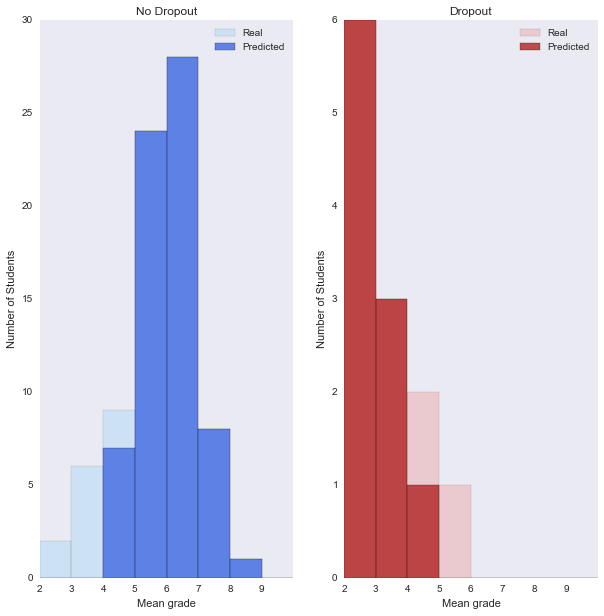

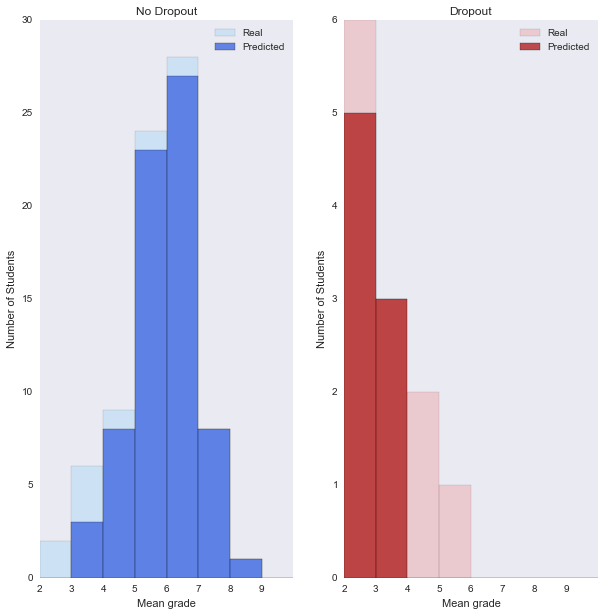

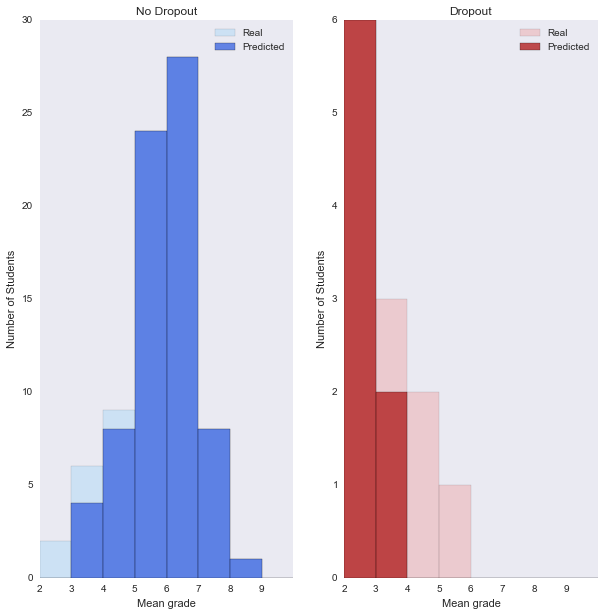

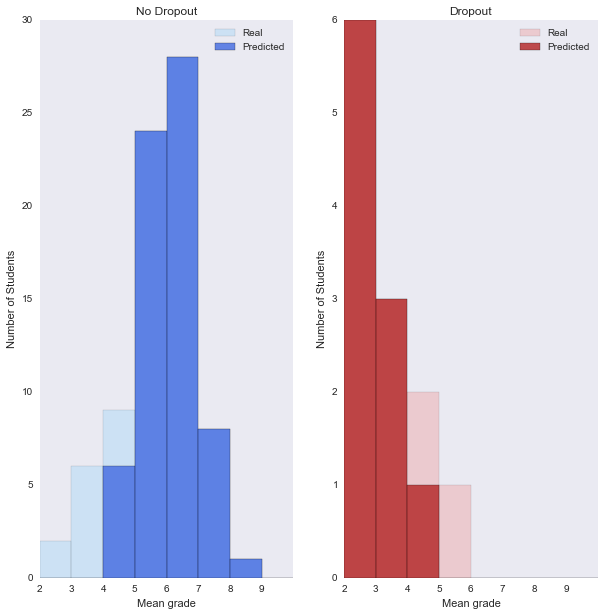

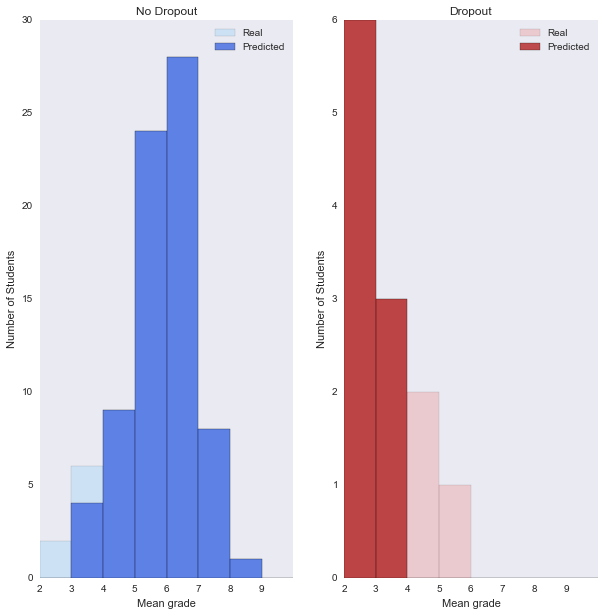

In [156]:
error_dataframes = createErrorDataFrames(predictions)
plotErrorDistribution(error_dataframes)

## 9. Permutation test 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.cross_validation import permutation_test_score
from sklearn import datasets

rf = pipes[-1]

score, permutation_scores, pvalue = permutation_test_score(
    rf, np.array(df_first), np.array(dropout_p), scoring = 'accuracy', cv=10, n_permutations=100, n_jobs=-1, random_state = random_state)
print("Classification score %s (pvalue : %s)" % (score, pvalue))